In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.metrics import f1_score
%matplotlib inline
np.random.seed(42)

df = pd.read_pickle('../data/train_transformed.p')
order_products_compact = pd.read_hdf('../data/online_retail.h5','order_products_compact')

def f1_score(l_true,l_pred):
    tp = set(l_true).intersection(set(l_pred))
    if not len(tp):
        return 0
    fp = set(l_pred).difference(tp)
    fn = set(l_true).difference(tp)
    p = len(tp) / (len(tp) + len(fp))
    r = len(tp) / (len(tp) + len(fn))
    f1 = 2 * (p * r) / (p + r)
    return f1
def avg_f1_score(df,pred,order_products_compact=order_products_compact,thres=0.05):
    df_pred = pd.DataFrame({'order_id':df.order_id,'pred':pred,'product_id':df.product_id,
                            'prior_size_max':df.user_order_size_max,
                            'prior_size_mean':df.user_order_size_mean,
                            'prior_size_std':df.user_order_size_std})\
                .sort_values(['order_id','pred'],ascending = [True,False]).reset_index(drop=True)
    df_pred['pred_rank'] = df_pred.groupby('order_id').cumcount()
    df_pred['prior_size_2std'] = df_pred.prior_size_mean + df_pred.prior_size_std * 2
    df_pred = df_pred[df_pred.pred_rank < df_pred.prior_size_max]\
            .reset_index(drop=True)
    d = {}
    for row in df_pred.itertuples():
        order_id = row.order_id
        if row.pred_rank == 0 or row.pred > thres:
            try:
                d[order_id] += ' ' + str(row.product_id)
            except:
                d[order_id] = str(row.product_id)
    df_pred_compact = pd.DataFrame.from_dict(d, orient='index')

    df_pred_compact.reset_index(inplace=True)
    df_pred_compact.columns = ['order_id', 'y_pred']
    df_pred_compact['y_pred'] = df_pred_compact['y_pred'].str.split()
    df_pred_compact = df_pred_compact.merge(order_products_compact[['order_id','product_id']],how='left',
                                                       on='order_id')
    scores = []
    for row in df_pred_compact.itertuples():
        y_pred = row.y_pred
        y_true = row.product_id
        score = f1_score(y_true,y_pred)
        scores.append(score)
    return np.mean(scores)
def auc_score(df,pred):
    return roc_auc_score(df['labels'].values,pred)

/home/song/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
f_to_use0 = ['user_total_orders',
       'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_order_size_mean',
       'user_total_item_quantity', 'user_total_spent',
       'user_sum_days_between_orders', 'user_reorder_ratio',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'product_orders', 'product_reorders', 'product_reorder_rate',
       'product_total_quantity_sold', 'product_avg_price', 'prod_first_buy',
       'prod_second_buy', 'prod_1reorder_ratio', 'prod_nreorder_ratio',
       'UP_orders', 'UP_orders_ratio', 'UP_reorder_rate', 'UP_total_quantity',
       'UP_order_rate_since_first_order']
f_to_use1 = ['user_total_orders',
       'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_order_size_mean',
       'user_total_item_quantity',
       'user_sum_days_between_orders', 'user_reorder_ratio',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'product_orders', 'product_reorder_rate',
       'product_total_quantity_sold', 'product_avg_price', 'prod_1reorder_ratio',
       'UP_orders', 'UP_orders_ratio', 'UP_total_quantity']
f_to_use2 = ['user_total_orders',
       'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_order_size_mean','user_order_size_max','user_order_size_std',
       'user_total_item_quantity', 'user_total_spent',
       'user_sum_days_between_orders', 'user_reorder_ratio',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'product_reorder_rate',
       'product_total_quantity_sold', 'product_avg_price', 'prod_first_buy',
       'prod_1reorder_ratio',
       'UP_orders', 'UP_orders_ratio', 'UP_total_quantity',
       'UP_order_rate_since_first_order']
f_to_use4 = ['user_total_orders', 'user_average_days_between_orders', 'user_order_size_mean', 
             'user_total_item_quantity', 'order_hour_of_day','order_dow', 'days_since_ratio',
             'product_orders', 'product_avg_price', 
             'UP_orders', 'UP_total_quantity', 
             'user_sum_days_between_orders','user_reorder_ratio','prod_1reorder_ratio']
f_to_use5 = ['user_reorder_ratio','prod_first_buy','user_order_size_mean','days_since_ratio']

In [84]:
df[f_to_use5].corr()

,user_reorder_ratio,prod_first_buy,user_order_size_mean,days_since_ratio
user_reorder_ratio,1.000000e+00,8.335906e-17,-7.893478e-02,-2.486770e-02
prod_first_buy,8.335906e-17,1.000000e+00,-2.843699e-18,-1.006647e-16
user_order_size_mean,-7.893478e-02,-2.843699e-18,1.000000e+00,-7.460674e-03
days_since_ratio,-2.486770e-02,-1.006647e-16,-7.460674e-03,1.000000e+00


In [13]:
corr = df[f_to_use2].corr()
(corr > 0.95).sum()

user_total_orders                   1
user_total_items                    1
total_distinct_items                1
user_average_days_between_orders    1
user_order_size_mean                1
user_order_size_max                 1
user_order_size_std                 1
user_total_item_quantity            1
user_total_spent                    1
user_sum_days_between_orders        1
user_reorder_ratio                  1
order_hour_of_day                   1
days_since_prior_order              1
days_since_ratio                    1
product_reorder_rate                1
product_total_quantity_sold         1
product_avg_price                   1
prod_first_buy                      1
prod_1reorder_ratio                 1
UP_orders                           1
UP_orders_ratio                     1
UP_total_quantity                   1
UP_order_rate_since_first_order     1
dtype: int64

In [14]:
corr

,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_order_size_mean,user_order_size_max,user_order_size_std,user_total_item_quantity,user_total_spent,user_sum_days_between_orders,...,days_since_ratio,product_reorder_rate,product_total_quantity_sold,product_avg_price,prod_first_buy,prod_1reorder_ratio,UP_orders,UP_orders_ratio,UP_total_quantity,UP_order_rate_since_first_order
user_total_orders,1.000000e+00,8.165736e-01,7.163151e-01,-4.123759e-01,-4.988595e-02,1.660630e-01,3.710501e-02,5.628045e-01,5.609762e-01,2.523834e-01,...,-1.020318e-01,-1.965402e-16,-5.785364e-18,1.907015e-19,-2.453117e-17,1.481277e-16,0.200472,0.000855,0.060087,0.012730
user_total_items,8.165736e-01,1.000000e+00,8.955118e-01,-2.732225e-01,3.060607e-01,4.781919e-01,3.088256e-01,4.704022e-01,4.277149e-01,1.734223e-01,...,-6.847880e-02,1.215257e-17,3.497120e-18,2.930313e-19,1.747566e-17,2.074457e-17,0.245504,0.039744,0.050222,0.053299
total_distinct_items,7.163151e-01,8.955118e-01,1.000000e+00,-2.733185e-01,5.280903e-01,7.009819e-01,5.285133e-01,4.459964e-01,3.926141e-01,2.140155e-01,...,-8.073580e-02,6.689366e-17,-1.460419e-18,1.443753e-18,3.246002e-18,-2.591635e-17,0.219852,0.064047,0.047616,0.081713
user_average_days_between_orders,-4.123759e-01,-2.732225e-01,-2.733185e-01,1.000000e+00,9.653803e-02,-8.503534e-02,-3.887627e-02,-2.358832e-01,-2.386266e-01,2.690539e-01,...,6.802189e-02,9.603240e-19,-2.196534e-18,2.671903e-18,3.554100e-18,-7.183409e-18,-0.067077,0.002860,-0.025184,-0.007002
user_order_size_mean,-4.988595e-02,3.060607e-01,5.280903e-01,9.653803e-02,1.000000e+00,8.683878e-01,7.538228e-01,2.012863e-02,2.023487e-03,-1.001512e-02,...,-7.460674e-03,-5.793121e-18,-1.659724e-18,2.982399e-18,-2.843699e-18,5.806308e-18,0.075139,0.107449,0.002149,0.109283
user_order_size_max,1.660630e-01,4.781919e-01,7.009819e-01,-8.503534e-02,8.683878e-01,1.000000e+00,9.216621e-01,1.907012e-01,1.573682e-01,6.451858e-02,...,-2.253865e-02,1.122269e-16,-8.134907e-18,-6.380486e-19,9.865983e-18,9.641773e-18,0.117398,0.096744,0.020360,0.106285
user_order_size_std,3.710501e-02,3.088256e-01,5.285133e-01,-3.887627e-02,7.538228e-01,9.216621e-01,1.000000e+00,1.101968e-01,8.653384e-02,-2.079162e-02,...,-1.517372e-03,7.757880e-17,-6.796925e-18,3.295155e-18,1.507652e-17,-1.649386e-17,0.075818,0.082818,0.011765,0.089446
user_total_item_quantity,5.628045e-01,4.704022e-01,4.459964e-01,-2.358832e-01,2.012863e-02,1.907012e-01,1.101968e-01,1.000000e+00,9.181255e-01,1.454924e-01,...,-7.512556e-02,7.364634e-18,5.195445e-18,1.311386e-18,-1.381355e-17,1.261048e-17,0.115486,0.005918,0.106763,0.012700
user_total_spent,5.609762e-01,4.277149e-01,3.926141e-01,-2.386266e-01,2.023487e-03,1.573682e-01,8.653384e-02,9.181255e-01,1.000000e+00,1.547752e-01,...,-7.937641e-02,-3.061170e-17,-7.924042e-19,-2.645946e-18,-1.886388e-17,-1.438819e-17,0.105006,0.003701,0.098022,0.009218
user_sum_days_between_orders,2.523834e-01,1.734223e-01,2.140155e-01,2.690539e-01,-1.001512e-02,6.451858e-02,-2.079162e-02,1.454924e-01,1.547752e-01,1.000000e+00,...,-1.380487e-01,6.265815e-17,2.060714e-18,-2.631253e-19,1.659722e-17,2.595913e-17,0.042576,0.004252,0.015533,0.016128


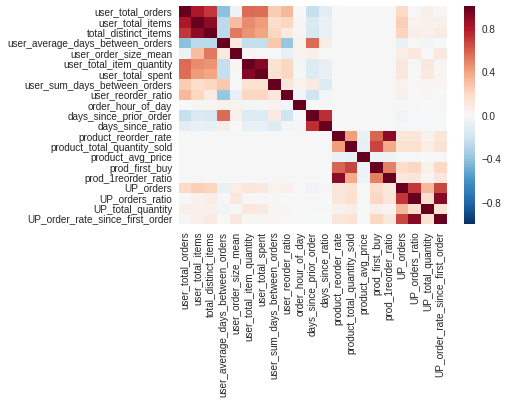

In [4]:
sns.heatmap(corr)

In [5]:
# train / val split
unique_users = df.user_id.unique()
np.random.shuffle(unique_users)
sp = int(len(unique_users)*0.8)
train_users = unique_users[:sp]
val_users = unique_users[sp:]
df_train = df[df.user_id.isin(train_users)]
df_val = df[df.user_id.isin(val_users)]

### basic logistical regression model

In [89]:
%%time
lgr = LogisticRegression(random_state=42,n_jobs=-1,C=100).fit(df_train[f_to_use4],df_train['labels'].values)
val_pred_lgr = lgr.predict_proba(df_val[f_to_use4])[:,1]

CPU times: user 1min 2s, sys: 264 ms, total: 1min 3s
Wall time: 1min 2s


In [91]:
for c in [0.01,0.1,1,10,100]:
    lgr = LogisticRegression(random_state=42,n_jobs=-1,C=c).fit(df_train[f_to_use4],df_train['labels'].values)
    val_pred_lgr = lgr.predict_proba(df_val[f_to_use4])[:,1]
    print (c,avg_f1_score(df_val,val_pred_lgr))

0.01 0.14828840153
0.1 0.146495709783
1 0.146057243031
10 0.146837420958
100 0.148087583855


In [92]:
for c in [0.001,1000]:
    lgr = LogisticRegression(random_state=42,n_jobs=-1,C=c).fit(df_train[f_to_use4],df_train['labels'].values)
    val_pred_lgr = lgr.predict_proba(df_val[f_to_use4])[:,1]
    print (c,avg_f1_score(df_val,val_pred_lgr))

0.001 0.145389106499
1000 0.147148270372


In [90]:
avg_f1_score(df_val,val_pred_lgr)

0.14649570978258367

In [82]:
auc_score(df_val,val_pred_lgr)

0.82624484752724636

### basic lgb model

In [95]:
%%time
d_train = lgb.Dataset(df_train[f_to_use2],label=df_train['labels'].values)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 128,
    'max_depth': 8,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'learning_rate': 0.053,
    # 'scale_pos_weight': 2
}

ROUNDS = 100
bst = lgb.train(params, d_train, ROUNDS)

val_pred_lgb = bst.predict(df_val[f_to_use2])

CPU times: user 2min 5s, sys: 412 ms, total: 2min 5s
Wall time: 16.4 s


In [96]:
avg_f1_score(df_val,val_pred_lgb)

0.20787485754632395

In [27]:
auc_score(df_val,val_pred_lgb)

0.88727561285789924

In [75]:
best_score = -1
best_param = None
count = 0
for thres in np.linspace(0.01,0.2,20):
    count += 1
    if count % 10 == 0:
        print (count)
    score = avg_f1_score(df_val,val_pred_lgb,thres=thres)
    if score > best_score:
        best_score = score
        best_param = thres
print (best_score,best_param)

10
20
0.215022120662 0.11


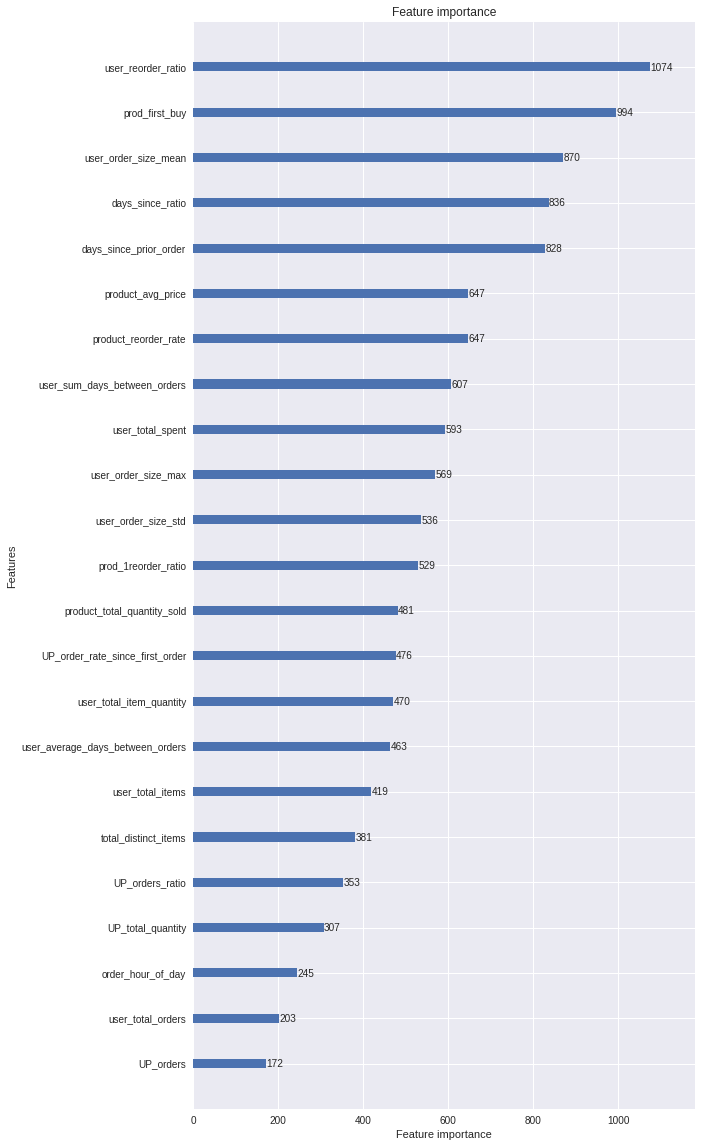

In [76]:
lgb.plot_importance(bst, figsize=(9,20))

In [40]:
np.linspace(0.021,0.029,9)

array([ 0.021,  0.022,  0.023,  0.024,  0.025,  0.026,  0.027,  0.028,
        0.029])

In [48]:
def lgb_lr(rang):
    best_score = -1
    best_param = None
    for lr in rang:
        d_train = lgb.Dataset(df_train[f_to_use2],label=df_train['labels'].values)

        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'binary_logloss'},
            'num_leaves': 128,
            'max_depth': 8,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.95,
            'bagging_freq': 5,
            'learning_rate': lr
        }

        ROUNDS = 100
        bst = lgb.train(params, d_train, ROUNDS)

        val_pred_lgb = bst.predict(df_val[f_to_use2])
        score = avg_f1_score(df_val,val_pred_lgb)
        print (score,lr)
        if score > best_score:
            best_score = score
            best_param = lr
    return best_param

In [37]:
def lgb_lr(rang):
    best_score = -1
    best_param = None
    for lr in np.linspace(0.01,0.1,10):
        d_train = lgb.Dataset(df_train[f_to_use2],label=df_train['labels'].values)

        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'binary_logloss'},
            'num_leaves': 128,
            'max_depth': 8,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.95,
            'bagging_freq': 5,
            'learning_rate': lr
        }

        ROUNDS = 100
        bst = lgb.train(params, d_train, ROUNDS)

        val_pred_lgb = bst.predict(df_val[f_to_use2])
        score = avg_f1_score(df_val,val_pred_lgb)
        print (score,lr)
        if score > best_score:
            best_score = score
            best_param = lr
        return 

0.208827634979 0.01
0.21034462303 0.02
0.211415235357 0.03
0.209352628561 0.04
0.212389011385 0.05
0.21143050437 0.06
0.211167497263 0.07
0.209347484472 0.08
0.209176190207 0.09
0.203499893794 0.1


In [51]:
lgb_lr(np.linspace(0.021,0.029,9))

0.210084487223 0.021
0.21130278877 0.022
0.213112586536 0.023
0.212837765525 0.024
0.213594559672 0.025
0.210505442668 0.026
0.211579353846 0.027
0.212650715562 0.028
0.211754595134 0.029


0.025000000000000001

In [47]:
lgb_lr(np.linspace(0.051,0.059,9))

0.210197996769 0.051
0.208986356882 0.052
0.213967797468 0.053
0.211963674216 0.054
0.213757047258 0.055
0.212378147281 0.056
0.213835073349 0.057
0.209104469583 0.058
0.208560177219 0.059


0.058999999999999997

In [12]:
best_score = -1
best_param = None
for num_leaves in [64,96,128,160,196]:
    for max_depth in [6,8,10,12,14]:
        d_train = lgb.Dataset(df_train[f_to_use2],label=df_train['labels'].values)

        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'binary_logloss'},
            'num_leaves': num_leaves,
            'max_depth': max_depth,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.95,
            'bagging_freq': 5,
            'learning_rate': 0.025
        }

        ROUNDS = 100
        bst = lgb.train(params, d_train, ROUNDS)

        val_pred_lgb = bst.predict(df_val[f_to_use2])
        score = avg_f1_score(df_val,val_pred_lgb)
        print (score,num_leaves,max_depth)
        if score > best_score:
            best_score = score
            best_param = (num_leaves,max_depth)

0.208987136235 64 6
0.211743834309 64 8
0.210504580805 64 10
0.210896493458 64 12
0.210375567581 64 14
0.208987136235 96 6
0.211962561654 96 8
0.2108177173 96 10
0.213182477478 96 12
0.213236405966 96 14
0.208987136235 128 6
0.213594559672 128 8
0.211911832653 128 10
0.212359704765 128 12
0.212797849677 128 14
0.208987136235 160 6
0.21276290466 160 8
0.212864685098 160 10
0.210859501892 160 12
0.211624392853 160 14
0.208987136235 196 6
0.213307304962 196 8
0.210294500302 196 10
0.211438302925 196 12
0.211889744837 196 14


In [17]:
best_param

(128, 8)

In [16]:
df_train['labels'].mean()

0.006001189451779529

### basic ramdom forest model

In [97]:
%%time
rfc = RandomForestClassifier(random_state = 42, n_estimators=100, max_depth = 5, n_jobs=-1).\
        fit(df_train[f_to_use2],df_train['labels'].values)
val_pred_rf = rfc.predict_proba(df_val[f_to_use2])[:,1]

CPU times: user 7min 3s, sys: 1.8 s, total: 7min 5s
Wall time: 55.8 s


In [99]:
for md in [4,5,6,7]:
    rfc = RandomForestClassifier(random_state = 42, n_estimators=100, max_depth = md, n_jobs=-1).\
        fit(df_train[f_to_use2],df_train['labels'].values)
    val_pred_rf = rfc.predict_proba(df_val[f_to_use2])[:,1]
    print (md,avg_f1_score(df_val,val_pred_rf))

4 0.208605970876
5 0.209893228298
6 0.209071935053
7 0.210982387178


In [100]:
for md in [8,9,10,11]:
    rfc = RandomForestClassifier(random_state = 42, n_estimators=100, max_depth = md, n_jobs=-1).\
        fit(df_train[f_to_use2],df_train['labels'].values)
    val_pred_rf = rfc.predict_proba(df_val[f_to_use2])[:,1]
    print (md,avg_f1_score(df_val,val_pred_rf))

8 0.209757639791
9 0.209564509079
10 0.209667844146
11 0.211559559915


In [101]:
for md in [12,13,14,15]:
    rfc = RandomForestClassifier(random_state = 42, n_estimators=100, max_depth = md, n_jobs=-1).\
        fit(df_train[f_to_use2],df_train['labels'].values)
    val_pred_rf = rfc.predict_proba(df_val[f_to_use2])[:,1]
    print (md,avg_f1_score(df_val,val_pred_rf))

12 0.20894537722
13 0.212293617041
14 0.212749431555
15 0.209896156822


In [103]:
for mss in [5,10,25,100]:
    rfc = RandomForestClassifier(random_state = 42, n_estimators=100, 
                                 max_depth = 7, n_jobs=-1,min_samples_split=mss).\
        fit(df_train[f_to_use2],df_train['labels'].values)
    val_pred_rf = rfc.predict_proba(df_val[f_to_use2])[:,1]
    print (mss,avg_f1_score(df_val,val_pred_rf))

5 0.209184216551
10 0.211014447251
25 0.210297244794
100 0.211680208049


In [105]:
for mss in [200,500,1000,2000]:
    rfc = RandomForestClassifier(random_state = 42, n_estimators=100, 
                                 max_depth = 7, n_jobs=-1,min_samples_split=mss).\
        fit(df_train[f_to_use2],df_train['labels'].values)
    val_pred_rf = rfc.predict_proba(df_val[f_to_use2])[:,1]
    print (mss,avg_f1_score(df_val,val_pred_rf))

200 0.210405818794
500 0.209972106493
1000 0.209164700886
2000 0.211289988911


In [104]:
df_train.shape

(3356168, 33)

In [98]:
avg_f1_score(df_val,val_pred_rf)

0.2098932282975392

In [35]:
auc_score(df_val,val_pred_rf)

0.87819660754253048

### basic xgb model

In [20]:
%%time
d_train = xgb.DMatrix(df_train[f_to_use2],label=df_train['labels'].values)

xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
ROUNDS = 100
watchlist= [(d_train, "train")]
bst = xgb.train(params=xgb_params, dtrain=d_train, num_boost_round=ROUNDS, evals=watchlist, verbose_eval=10)
# xgboost.plot_importance(bst)
val_pred_xgb = bst.predict(xgb.DMatrix(df_val[f_to_use2]))

[0]	train-logloss:0.600261
[10]	train-logloss:0.189662
[20]	train-logloss:0.079311
[30]	train-logloss:0.043712
[40]	train-logloss:0.031994
[50]	train-logloss:0.028181
[60]	train-logloss:0.026866
[70]	train-logloss:0.026348
[80]	train-logloss:0.026067
[90]	train-logloss:0.025836
CPU times: user 16min 22s, sys: 1.97 s, total: 16min 24s
Wall time: 2min 4s


In [106]:
for md in [6,7,8,9,10]:
    d_train = xgb.DMatrix(df_train[f_to_use2],label=df_train['labels'].values)

    xgb_params = {
        "objective"         : "reg:logistic"
        ,"eval_metric"      : "logloss"
        ,"eta"              : 0.1
        ,"max_depth"        : md
        ,"min_child_weight" :10
        ,"gamma"            :0.70
        ,"subsample"        :0.76
        ,"colsample_bytree" :0.95
        ,"alpha"            :2e-05
        ,"lambda"           :10
    }
    ROUNDS = 100
    bst = xgb.train(params=xgb_params, dtrain=d_train, num_boost_round=ROUNDS)
    val_pred_xgb = bst.predict(xgb.DMatrix(df_val[f_to_use2]))
    print (md,avg_f1_score(df_val,val_pred_xgb))

6 0.209265352359
7 0.214900017466
8 0.214972036223
9 0.21255375745
10 0.213939004322


In [7]:
for eta in [0.25,0.5,0.75]:
    d_train = xgb.DMatrix(df_train[f_to_use2],label=df_train['labels'].values)

    xgb_params = {
        "objective"         : "reg:logistic"
        ,"eval_metric"      : "logloss"
        ,"eta"              : eta
        ,"max_depth"        : 7
        ,"min_child_weight" :10
        ,"gamma"            :0.70
        ,"subsample"        :0.76
        ,"colsample_bytree" :0.95
        ,"alpha"            :2e-05
        ,"lambda"           :10
    }
    ROUNDS = 100
    bst = xgb.train(params=xgb_params, dtrain=d_train, num_boost_round=ROUNDS)
    val_pred_xgb = bst.predict(xgb.DMatrix(df_val[f_to_use2]))
    print (eta,avg_f1_score(df_val,val_pred_xgb))

0.25 0.214949523102
0.5 0.203288509629
0.75 0.184216194004


In [14]:
for p in [2e-06,2e-04]:
    d_train = xgb.DMatrix(df_train[f_to_use2],label=df_train['labels'].values)

    xgb_params = {
        "objective"         : "reg:logistic"
        ,"eval_metric"      : "logloss"
        ,"eta"              : 0.1
        ,"max_depth"        : 7
        ,"min_child_weight" :10
        ,"gamma"            :0.7
        ,"subsample"        :0.76
        ,"colsample_bytree" :0.95
        ,"alpha"            :p
        ,"lambda"           :10
    }
    ROUNDS = 100
    bst = xgb.train(params=xgb_params, dtrain=d_train, num_boost_round=ROUNDS)
    val_pred_xgb = bst.predict(xgb.DMatrix(df_val[f_to_use2]))
    print (p,avg_f1_score(df_val,val_pred_xgb))

2e-06 0.214900017466
0.0002 0.214900017466


In [28]:
avg_f1_score(df_val,val_pred_xgb)

0.20926535235940641

In [22]:
auc_score(df_val,val_pred_xgb)

0.8910738594257438

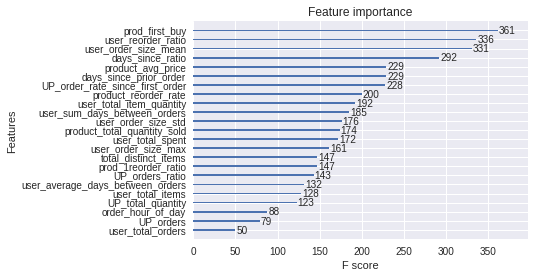

In [18]:
xgb.plot_importance(bst)

In [45]:
avg_f1_score(df_val,.3*val_pred_xgb+.3*val_pred_lgb+.3*val_pred_rf+.1*val_pred_lgr)

0.21363914123624578

In [82]:
np.linspace(0.5,2.5,21)

array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,
        1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5])

In [29]:
best_score = -1
best_param = None
count = 0
for thres in np.linspace(0.01,0.2,20):
    count += 1
    if count % 10 == 0:
        print (count)
    score = avg_f1_score(df_val,val_pred_xgb,thres=thres)
    if score > best_score:
        best_score = score
        best_param = thres
print (best_score,best_param)

10
20
0.213244858178 0.07


# Group K Fold CV

In [53]:
def group_kfold_cv(model = LogisticRegression(random_state=42,n_jobs=-1),f_to_use = f_to_use3):
    group_kfold = GroupKFold(n_splits=4)
    avg_f1_score_list = []
    auc_score_list = []
    i = 0
    df_shuffle = df.sample(frac=1,random_state=43).reset_index(drop=True)
    for train_index, val_index in group_kfold.split(
        X = df_shuffle[f_to_use].values, groups = df_shuffle['order_id'].values):
        i += 1
        print ('Fold {}...'.format(i))
        df_train = df_shuffle.loc[train_index]
        df_val = df_shuffle.loc[val_index]
        m = model.fit(df_train[f_to_use],df_train['labels'].values)
        val_pred = m.predict_proba(df_val[f_to_use])[:,1]
        avg_f1_score_list.append(avg_f1_score(df_val,val_pred))
        auc_score_list.append(auc_score(df_val,val_pred))
    return np.mean(avg_f1_score_list),np.mean(auc_score_list)

def group_kfold_lgb(f_to_use = f_to_use3):
    group_kfold = GroupKFold(n_splits=4)
    avg_f1_score_list = []
    auc_score_list = []
    i = 0
    df_shuffle = df.sample(frac=1,random_state=43).reset_index(drop=True)
    for train_index, val_index in group_kfold.split(
        X = df_shuffle[f_to_use].values, groups = df_shuffle['order_id'].values):
        i += 1
        print ('Fold {}...'.format(i))
        df_train = df_shuffle.loc[train_index]
        df_val = df_shuffle.loc[val_index]
        d_train = lgb.Dataset(df_train[f_to_use],label=df_train['labels'].values)
        params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'binary_logloss'},
        'num_leaves': 96,
        'max_depth': 10,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.95,
        'bagging_freq': 5
        }
        ROUNDS = 100
        bst = lgb.train(params, d_train, ROUNDS)
        val_pred = bst.predict(df_val[f_to_use])
        avg_f1_score_list.append(avg_f1_score(df_val,val_pred))
        auc_score_list.append(auc_score(df_val,val_pred))
    return np.mean(avg_f1_score_list),np.mean(auc_score_list)

def group_kfold_xgb(f_to_use = f_to_use3):
    group_kfold = GroupKFold(n_splits=4)
    avg_f1_score_list = []
    auc_score_list = []
    i = 0
    df_shuffle = df.sample(frac=1,random_state=43).reset_index(drop=True)
    for train_index, val_index in group_kfold.split(
        X = df_shuffle[f_to_use].values, groups = df_shuffle['order_id'].values):
        i += 1
        print ('Fold {}...'.format(i))
        df_train = df_shuffle.loc[train_index]
        df_val = df_shuffle.loc[val_index]
        d_train = xgb.DMatrix(df_train[f_to_use],label=df_train['labels'].values)

        xgb_params = {
            "objective"         : "reg:logistic"
            ,"eval_metric"      : "logloss"
            ,"eta"              : 0.1
            ,"max_depth"        : 6
            ,"min_child_weight" :10
            ,"gamma"            :0.70
            ,"subsample"        :0.76
            ,"colsample_bytree" :0.95
            ,"alpha"            :2e-05
            ,"lambda"           :10
        }
        ROUNDS = 100
#         watchlist= [(d_train, "train")]
        bst = xgb.train(params=xgb_params, dtrain=d_train, num_boost_round=ROUNDS)
        val_pred = bst.predict(xgb.DMatrix(df_val[f_to_use]))
        avg_f1_score_list.append(avg_f1_score(df_val,val_pred))
        auc_score_list.append(auc_score(df_val,val_pred))
    return np.mean(avg_f1_score_list),np.mean(auc_score_list)

In [60]:
%%time
group_kfold_cv()

Fold 1...
Fold 2...
Fold 3...
Fold 4...
CPU times: user 1min 10s, sys: 2.32 s, total: 1min 12s
Wall time: 1min 10s


(0.13208674109339155, 0.83524917996384851)

In [61]:
%%time
group_kfold_cv(RandomForestClassifier(random_state = 42, n_estimators=100, max_depth = 5, n_jobs=-1))

Fold 1...
Fold 2...
Fold 3...
Fold 4...
CPU times: user 26min 12s, sys: 10.2 s, total: 26min 22s
Wall time: 3min 32s


(0.17959987400227559, 0.8660472661686186)

In [64]:
%%time
group_kfold_lgb()

Fold 1...
Fold 2...
Fold 3...
Fold 4...
CPU times: user 7min 59s, sys: 1.3 s, total: 8min
Wall time: 1min 4s


(0.17928740680159366, 0.87701008867151198)

In [23]:
%%time
group_kfold_xgb()

Fold 1...
Fold 2...
Fold 3...
Fold 4...
CPU times: user 1h 4min 1s, sys: 10.4 s, total: 1h 4min 12s
Wall time: 8min 24s


(0.18824797592072021, 0.8803443391638035)